<a href="https://colab.research.google.com/github/giorgitorro/FER_gtoro22/blob/main/FER2013_ML_gtoro22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio
!pip install wandb
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"giorgitoronjadze","key":"82572ceeacdd135dce03ab6b1a5379a1"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!pip install opendatasets

In [5]:
import opendatasets as od

In [6]:
od.download("https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/overview")

100%|██████████| 285M/285M [00:00<00:00, 407MB/s]


Extracting archive ./challenges-in-representation-learning-facial-expression-recognition-challenge/challenges-in-representation-learning-facial-expression-recognition-challenge.zip to ./challenges-in-representation-learning-facial-expression-recognition-challenge


In [7]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gtoro22 (gtoro22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [8]:
!git init
!git config --global user.email "gtoro22@freeuni.edu.ge"
!git config --global user.name "giorgitorro"
!git remote add origin https://github.com/giorgitorro/FER_gtoro22.git

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [9]:
import pandas as pd

df = pd.read_csv("/content/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv")
print(df.head())
print(df.columns)

   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
Index(['emotion', 'pixels'], dtype='object')


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import wandb
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

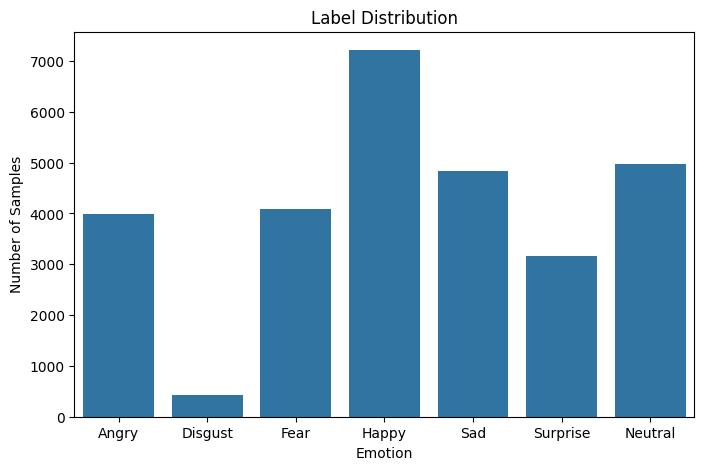

In [11]:
emotion_labels = {
    0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy",
    4: "Sad", 5: "Surprise", 6: "Neutral"
}

plt.figure(figsize=(8, 5))
sns.countplot(x='emotion', data=df)
plt.title("Label Distribution")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(ticks=range(7), labels=[emotion_labels[i] for i in range(7)])
plt.show()


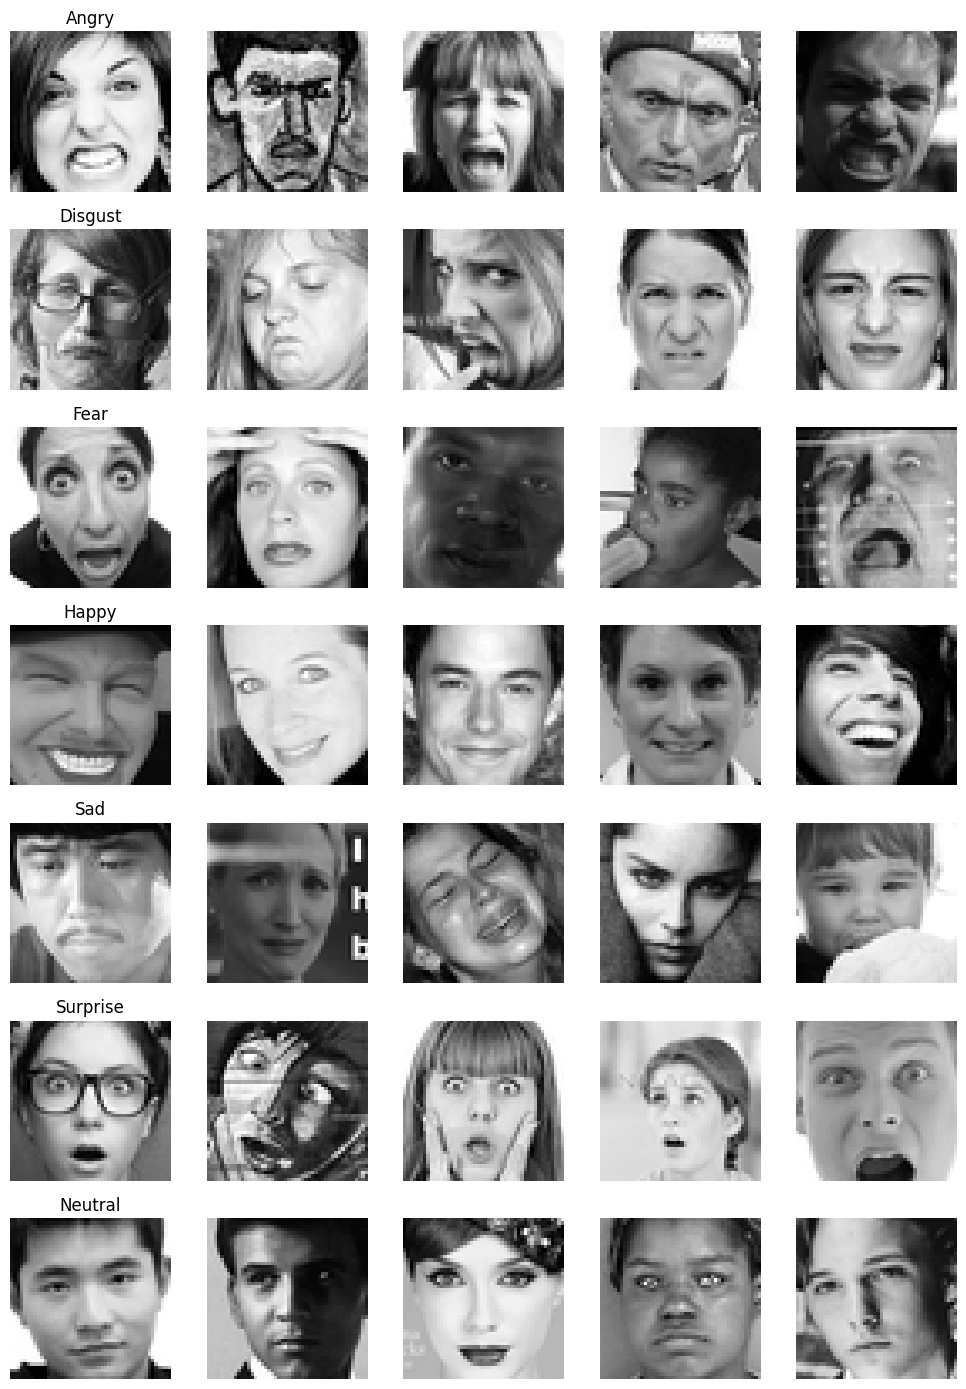

In [12]:
def show_images_per_class(df, n=5):
    fig, axes = plt.subplots(7, n, figsize=(n*2, 14))
    for label in range(7):
        subset = df[df['emotion'] == label].sample(n)
        for i, row in enumerate(subset.itertuples()):
            pixels = np.fromstring(row.pixels, sep=' ', dtype=np.uint8).reshape(48, 48)
            axes[label, i].imshow(pixels, cmap='gray')
            axes[label, i].axis('off')
            if i == 0:
                axes[label, i].set_title(emotion_labels[label])
    plt.tight_layout()
    plt.show()

show_images_per_class(df, n=5)

In [13]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomCrop(48, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [43]:
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None, has_labels=True):
        self.data = dataframe
        self.transform = transform
        self.has_labels = has_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = np.fromstring(self.data.iloc[idx]['pixels'], sep=' ', dtype=np.uint8).reshape(48, 48)
        image = Image.fromarray(pixels, mode='L')

        if self.transform:
            image = self.transform(image)

        if self.has_labels:
            label = int(self.data.iloc[idx]['emotion'])
            return image, label
        else:
            return image

In [44]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=42)
test_df = pd.read_csv('/content/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv')
train_dataset = FERDataset(train_df, transform=transform_train, has_labels=True)
val_dataset = FERDataset(val_df, transform=transform_val,has_labels=True)
test_dataset = FERDataset(test_df, transform=transform_val,has_labels=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


In [36]:
# Simple CNN (baseline)
class CNN_model_1(nn.Module):
    def __init__(self):
        super(CNN_model_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 48→24
        x = self.pool(F.relu(self.conv2(x)))  # 24→12
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNN_model_2(nn.Module):
    def __init__(self, dropout_rate=0.25):
        super(CNN_model_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CNN_model_3(nn.Module):
    def __init__(self, num_classes=7):
        super(CNN_model_3, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(64, 64, 2, stride=1)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)  # 48→24
        self.layer3 = self.make_layer(128, 256, 2, stride=2)  # 24→12
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_classes)

    def make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [37]:
# Training function with wandb logging
def train_model(model, train_loader, val_loader, config, run_name):
    wandb.init(project="fer2013", name=run_name, config=config)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    class_counts = train_df['emotion'].value_counts().sort_index()
    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
    class_weights = class_weights / class_weights.sum() * len(class_counts)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)
    best_val_acc = 0
    patience = config['patience']
    counter = 0
    for epoch in range(config['epochs']):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)
        model.eval()
        val_correct = 0
        val_total = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        val_acc = val_correct / val_total
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        wandb.log({"confusion_matrix": wandb.Image(plt), "epoch": epoch + 1})
        plt.close()
        wandb.log({"train_accuracy": train_acc, "val_accuracy": val_acc, "train_loss": avg_loss, "epoch": epoch + 1})
        print(f"{run_name} Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}, Loss = {avg_loss:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_model_{run_name}.pth')
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        scheduler.step(val_acc)
    wandb.finish()
    return best_val_acc

In [38]:
# Experiment configurations
# Rationale: Test multiple models and hyperparameters to analyze performance and underfitting/overfitting.
experiments = [
    {"model": CNN_model_1(), "name": "CNN_model_1_lr_0.001",
     "config": {"architecture": "CNN_model_1", "learning_rate": 0.001, "epochs": 30,
                "batch_size": 64, "dropout": 0.0, "patience": 5}},
    {"model": CNN_model_2(dropout_rate=0.25), "name": "CNN_model_2_lr_0.001_dropout_0.25",
     "config": {"architecture": "CNN_model_2", "learning_rate": 0.001, "epochs": 30,
                "batch_size": 64, "dropout": 0.25, "patience": 5}},
    {"model": CNN_model_2(dropout_rate=0.5), "name": "CNN_model_2_lr_0.0003_dropout_0.5",
     "config": {"architecture": "CNN_model_2", "learning_rate": 0.0003, "epochs": 30,
                "batch_size": 64, "dropout": 0.5, "patience": 5}},
    {"model": CNN_model_3(), "name": "CNN_model_3_lr_0.001_dropout_0.5",
     "config": {"architecture": "CNN_model_3", "learning_rate": 0.001, "epochs": 30,
                "batch_size": 64, "dropout": 0.5, "patience": 5}}
]

# Run experiments
results = []
for exp in experiments:
    print(f"Running experiment: {exp['name']}")
    val_acc = train_model(exp['model'], train_loader, val_loader, exp['config'], exp['name'])
    results.append({"name": exp['name'], "val_accuracy": val_acc})

# Log results summary
wandb.init(project="fer2013", name="experiment_summary")
table = wandb.Table(columns=["Experiment", "Validation Accuracy"])
for result in results:
    table.add_data(result["name"], result["val_accuracy"])
wandb.log({"experiment_comparison": table})
wandb.finish()

Running experiment: CNN_model_1_lr_0.001


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
train_accuracy,▁▂▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇███████████
train_loss,█▇▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▃▆▅▅▆▆▇▆▆▇▇▇▇▇▇████████████
epoch,30
train_accuracy,0.39761
train_loss,1.56144
val_accuracy,0.4131


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


CNN_model_1_lr_0.001 Epoch 1: Train Acc = 0.2036, Val Acc = 0.2534, Loss = 1.9110
CNN_model_1_lr_0.001 Epoch 2: Train Acc = 0.2636, Val Acc = 0.3312, Loss = 1.8508
CNN_model_1_lr_0.001 Epoch 3: Train Acc = 0.2878, Val Acc = 0.3586, Loss = 1.7914
CNN_model_1_lr_0.001 Epoch 4: Train Acc = 0.3192, Val Acc = 0.4152, Loss = 1.7478
CNN_model_1_lr_0.001 Epoch 5: Train Acc = 0.3398, Val Acc = 0.3882, Loss = 1.7188
CNN_model_1_lr_0.001 Epoch 6: Train Acc = 0.3451, Val Acc = 0.4002, Loss = 1.6990
CNN_model_1_lr_0.001 Epoch 7: Train Acc = 0.3595, Val Acc = 0.4312, Loss = 1.6732
CNN_model_1_lr_0.001 Epoch 8: Train Acc = 0.3650, Val Acc = 0.4302, Loss = 1.6484
CNN_model_1_lr_0.001 Epoch 9: Train Acc = 0.3724, Val Acc = 0.4432, Loss = 1.6422
CNN_model_1_lr_0.001 Epoch 10: Train Acc = 0.3796, Val Acc = 0.4352, Loss = 1.6259
CNN_model_1_lr_0.001 Epoch 11: Train Acc = 0.3823, Val Acc = 0.4446, Loss = 1.6092
CNN_model_1_lr_0.001 Epoch 12: Train Acc = 0.3921, Val Acc = 0.4573, Loss = 1.5865
CNN_model_1_l

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇█████
train_loss,█▇▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁
val_accuracy,▁▃▄▆▅▅▆▆▇▆▇▇▆█▇█▇█▇██
epoch,21
train_accuracy,0.42404
train_loss,1.49184
val_accuracy,0.48415


Running experiment: CNN_model_2_lr_0.001_dropout_0.25


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


CNN_model_2_lr_0.001_dropout_0.25 Epoch 1: Train Acc = 0.1972, Val Acc = 0.2165, Loss = 1.9251
CNN_model_2_lr_0.001_dropout_0.25 Epoch 2: Train Acc = 0.2352, Val Acc = 0.3245, Loss = 1.8557
CNN_model_2_lr_0.001_dropout_0.25 Epoch 3: Train Acc = 0.2973, Val Acc = 0.3445, Loss = 1.7864
CNN_model_2_lr_0.001_dropout_0.25 Epoch 4: Train Acc = 0.3150, Val Acc = 0.3823, Loss = 1.7446
CNN_model_2_lr_0.001_dropout_0.25 Epoch 5: Train Acc = 0.3225, Val Acc = 0.3683, Loss = 1.7081
CNN_model_2_lr_0.001_dropout_0.25 Epoch 6: Train Acc = 0.3352, Val Acc = 0.4209, Loss = 1.6774
CNN_model_2_lr_0.001_dropout_0.25 Epoch 7: Train Acc = 0.3566, Val Acc = 0.4105, Loss = 1.6564
CNN_model_2_lr_0.001_dropout_0.25 Epoch 8: Train Acc = 0.3660, Val Acc = 0.4687, Loss = 1.6119
CNN_model_2_lr_0.001_dropout_0.25 Epoch 9: Train Acc = 0.3715, Val Acc = 0.3748, Loss = 1.6034
CNN_model_2_lr_0.001_dropout_0.25 Epoch 10: Train Acc = 0.3822, Val Acc = 0.4533, Loss = 1.5860
CNN_model_2_lr_0.001_dropout_0.25 Epoch 11: Train

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▂▄▄▅▅▆▆▆▆▇▇▇█████████
train_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▅▆▆▇▅▇▇▇██████████
epoch,22
train_accuracy,0.43336
train_loss,1.44503
val_accuracy,0.49704


Running experiment: CNN_model_2_lr_0.0003_dropout_0.5


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


CNN_model_2_lr_0.0003_dropout_0.5 Epoch 1: Train Acc = 0.1802, Val Acc = 0.2271, Loss = 1.9367
CNN_model_2_lr_0.0003_dropout_0.5 Epoch 2: Train Acc = 0.2013, Val Acc = 0.2356, Loss = 1.9050
CNN_model_2_lr_0.0003_dropout_0.5 Epoch 3: Train Acc = 0.2144, Val Acc = 0.2301, Loss = 1.8669
CNN_model_2_lr_0.0003_dropout_0.5 Epoch 4: Train Acc = 0.2536, Val Acc = 0.2109, Loss = 1.8293
CNN_model_2_lr_0.0003_dropout_0.5 Epoch 5: Train Acc = 0.2705, Val Acc = 0.3413, Loss = 1.8009
CNN_model_2_lr_0.0003_dropout_0.5 Epoch 6: Train Acc = 0.2892, Val Acc = 0.3856, Loss = 1.7704
CNN_model_2_lr_0.0003_dropout_0.5 Epoch 7: Train Acc = 0.3040, Val Acc = 0.3011, Loss = 1.7451
CNN_model_2_lr_0.0003_dropout_0.5 Epoch 8: Train Acc = 0.3127, Val Acc = 0.3776, Loss = 1.7201
CNN_model_2_lr_0.0003_dropout_0.5 Epoch 9: Train Acc = 0.3278, Val Acc = 0.4025, Loss = 1.7095
CNN_model_2_lr_0.0003_dropout_0.5 Epoch 10: Train Acc = 0.3345, Val Acc = 0.3962, Loss = 1.6766
CNN_model_2_lr_0.0003_dropout_0.5 Epoch 11: Train

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_accuracy,▁▂▂▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
train_loss,██▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁
val_accuracy,▁▂▁▁▄▅▃▅▆▆▆▇▆▆▇▇▇▇▇▇▇█▇███████
epoch,30
train_accuracy,0.4115
train_loss,1.50174
val_accuracy,0.49408


Running experiment: CNN_model_3_lr_0.001_dropout_0.5


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


CNN_model_3_lr_0.001_dropout_0.5 Epoch 1: Train Acc = 0.1733, Val Acc = 0.2316, Loss = 1.9622
CNN_model_3_lr_0.001_dropout_0.5 Epoch 2: Train Acc = 0.1962, Val Acc = 0.1963, Loss = 1.8984
CNN_model_3_lr_0.001_dropout_0.5 Epoch 3: Train Acc = 0.2588, Val Acc = 0.3232, Loss = 1.8093
CNN_model_3_lr_0.001_dropout_0.5 Epoch 4: Train Acc = 0.3347, Val Acc = 0.4138, Loss = 1.7215
CNN_model_3_lr_0.001_dropout_0.5 Epoch 5: Train Acc = 0.3792, Val Acc = 0.4326, Loss = 1.6364
CNN_model_3_lr_0.001_dropout_0.5 Epoch 6: Train Acc = 0.4012, Val Acc = 0.2839, Loss = 1.5773
CNN_model_3_lr_0.001_dropout_0.5 Epoch 7: Train Acc = 0.4156, Val Acc = 0.4134, Loss = 1.5225
CNN_model_3_lr_0.001_dropout_0.5 Epoch 8: Train Acc = 0.4360, Val Acc = 0.4775, Loss = 1.4712
CNN_model_3_lr_0.001_dropout_0.5 Epoch 9: Train Acc = 0.4504, Val Acc = 0.5155, Loss = 1.4360
CNN_model_3_lr_0.001_dropout_0.5 Epoch 10: Train Acc = 0.4655, Val Acc = 0.4664, Loss = 1.4021
CNN_model_3_lr_0.001_dropout_0.5 Epoch 11: Train Acc = 0.48

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
train_accuracy,▁▁▂▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████
train_loss,██▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▂▁▃▅▅▂▅▆▆▅▆▇▆▇▇▇▇▇▇▇▇█▇█▇█████
epoch,30
train_accuracy,0.62176
train_loss,0.95806
val_accuracy,0.62313


In [45]:
# Generate Kaggle submission with best model
# Rationale: Use the model with highest validation accuracy for submission.
best_exp = max(results, key=lambda x: x['val_accuracy'])
best_model = [exp['model'] for exp in experiments if exp['name'] == best_exp['name']][0]
best_model.load_state_dict(torch.load(f'best_model_{best_exp["name"]}.pth'))
best_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(device)
predictions = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = best_model(images)
        preds = outputs.argmax(dim=1)
        predictions.extend(preds.cpu().numpy())
submission = pd.DataFrame({'Id': range(len(predictions)), 'emotion': predictions})
submission.to_csv('submission.csv', index=False)
print("Submission file generated: submission.csv")

Submission file generated: submission.csv


In [46]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>